In [161]:
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import tensorflow as tf
import tqdm as tqdm
import matplotlib.pyplot as plt

In [7]:
folder = 'C:/Users/Conaf/Desktop/Generacion_Vectores_deepglobe/tiles-128/'
df_tiles_128_balanced = pd.read_csv('C:/Users/Conaf/Desktop/Generacion_Vectores_deepglobe/df_labeled-128.csv').dropna()

In [4]:
# Limitamos a 50.000 el número máximo de muestras, asegurando que haya la misma cantidad de cada clase

cut_number = 50000
classes = df_tiles_128_balanced['label'].unique()
df_small = pd.DataFrame(columns=['image_name', 'label'])

for class_name in classes:
    class_samples = df_tiles_128_balanced[df_tiles_128_balanced['label'] == class_name]
    # Samples por clase
    num_samples = min(cut_number // len(classes), len(class_samples))
    # Randomly undersampled balanced
    class_samples_balanced = resample(
        class_samples,
        replace = False,
        n_samples = num_samples,
        random_state = 42
    )
    df_small = df_small.append(class_samples_balanced, ignore_index=True)
    
# Randomly shuffled    
df_small = df_small.sample(frac=1, random_state=42).reset_index(drop=True)

C:\Users\Conaf\AppData\Local\Temp\ipykernel_18060\4292388907.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_small = df_small.append(class_samples_balanced, ignore_index=True)


In [8]:
df_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43005 entries, 0 to 43004
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  43005 non-null  object
 1   label       43005 non-null  object
dtypes: object(2)
memory usage: 672.1+ KB


In [6]:
class_to_rgb = {
    'urban_land': (0, 255, 255),
    'agriculture_land': (255, 255, 0),
    'rangeland': (255, 0, 255),
    'forest_land': (0, 255, 0),
    'water': (0, 0, 255),
    'barren_land': (255, 255, 255),
    'unknown': (0, 0, 0)
}

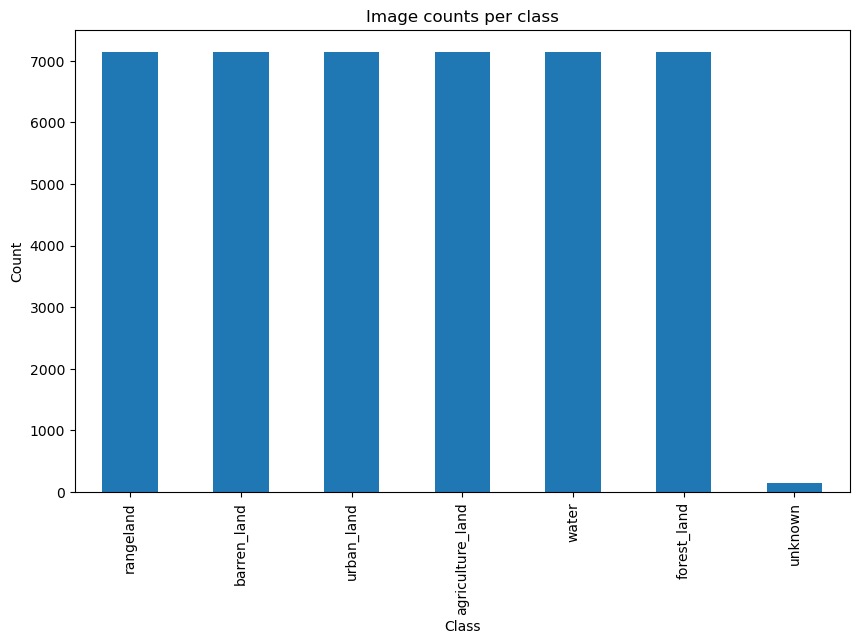

rangeland           7142
barren_land         7142
urban_land          7142
agriculture_land    7142
water               7142
forest_land         7142
unknown              153
Name: label, dtype: int64


In [7]:
class_counts = df_small['label'].value_counts()

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Image counts per class')
plt.xticks(range(len(class_counts.index)), class_counts.index)
plt.show()

print(class_counts)

In [11]:
df_small.to_csv('C:/Users/Conaf/Desktop/Generacion_Vectores_deepglobe/df-128_small.csv', index=False)

Una vez que tenemos el df con la misma cantidad de muestras de cada clase, procesamos y cargamos las imágenes, que serán guardadas como array para poder utilizarlas posteriormente ya preprocesadas

In [8]:
from tqdm import tqdm

# Process and load images

def load_process_images(folder, df, size=128, batch_size=32):
    width = size
    height = size

    image_files = df['image_name'].tolist()

    # Initialize list to store image data
    images = []

    # Loop through the image files
    for start_idx in tqdm(range(0, len(image_files), batch_size), desc="Processing..."):
        #print(image_file)

        end_idx = start_idx + batch_size
        batch_files = image_files[start_idx:end_idx]

        batch_images = []
        for image_file in batch_files:
            
            # Construct the full file paths
            image_path = os.path.join(folder, image_file)

            # Load the image 
            image = cv2.imread(image_path)
            # Check if the image is None
            if image is None:
                print(f"Error loading image or mask: {image_file}")
                continue  # Skip this image

            # Resize the image
            image = cv2.resize(image, (width, height))

            # Normalize the image to values between 0 and 1
            image = image.astype(np.float32) / 255.0
            batch_images.append(image)
        # Append the image a to its list
        images.extend(batch_images)

    # Convert the lists of image to NumPy arrays
    images = np.array(images)

    return images

In [9]:
images = load_process_images(folder, df=df_small)

Processing...: 100%|██████████| 1344/1344 [00:30<00:00, 43.61it/s]


In [10]:
# Save the data as a compressed NumPy archive
np.savez_compressed('C:/Users/Conaf/Desktop/Generacion_Vectores_deepglobe/datacompressed-128_small.npz', images=images)